In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy
import math

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-fmn895cg
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-fmn895cg
  Resolved https://github.com/vanbreugel-lab/pybounds to commit b847eb839f75308ed8ba402f0e3356f6148d465e
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19568 sha256=774fc9ebf74e4318848c20467b6915598cfd386dcdb9bc44aadb86154bfdacb3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jjgzacd_/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [3]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Dynamics and measurement functions

In [4]:
# UGV dynamics
params = dict(m=20.0, kv=300.0, bv=20.0,
              Iz=1.0, kw=50.0, bw=2.0)

def f(x, u, m=params['m'], kv=params['kv'], bv=params['bv'], Iz=params['Iz'], kw=params['kw'], bw=params['bw']):
    """
    UGV dynamics in continuous time for odeint.
    """
    v_cmd, w_cmd = u

    # Unpack state
    X, Y, theta, xdot, ydot, thetadot = x

    # Body-frame forward velocity
    v_body = np.cos(theta) * xdot + np.sin(theta) * ydot

    # Effective acceleration coefficients
    alpha_v = kv / m
    gamma_v = (kv + bv) / m
    alpha_w = kw / Iz
    gamma_w = (kw + bw) / Iz

    # Accelerations
    xddot = -gamma_v * v_body * np.cos(theta) + alpha_v * np.cos(theta) * v_cmd
    yddot = -gamma_v * v_body * np.sin(theta) + alpha_v * np.sin(theta) * v_cmd
    thetaddot = -gamma_w * thetadot + alpha_w * w_cmd

    # Collect derivatives
    return np.array([
        xdot,       # dx/dt
        ydot,       # dy/dt
        thetadot,   # dtheta/dt
        xddot,      # d(xdot)/dt
        yddot,      # d(ydot)/dt
        thetaddot   # d(thetadot)/dt
    ])

In [5]:
def h_all(x_vec, u_vec):
    # Extract state variables
    X = x_vec[0]
    Y = x_vec[1]
    theta = x_vec[2]
    xdot = x_vec[3]
    ydot = x_vec[4]
    thetadot = x_vec[5]

    # Extract control inputs
    v = u_vec[0]
    w = u_vec[1]

    aruco_pos = (20, 20)
    aruco_pos2 = (-5, -5)

    #Add gaussian noise to measurements
    v_body = np.cos(theta) * xdot + np.sin(theta) * ydot
    x_aruco = abs(aruco_pos[0] - X)
    y_aruco = abs(aruco_pos[1] - Y)
    euc_aruco = math.dist(aruco_pos, (X, Y))
    euc_aruco2 = math.dist(aruco_pos2, (X, Y))
    # Measurements
    y_vec = [v_body, thetadot, theta, euc_aruco, euc_aruco2]  # position and heading



    # Return measurement
    return np.array(y_vec)

# Run MPC simulation

In [219]:
#Simulator
state_names = ['X', 'Y', 'theta', 'xdot', 'ydot', 'thetadot']
input_names = ['v', 'w']

measurement_names = ['v_body', 'thetadot', 'theta', 'euc_aruco', 'euc_aruco2']
#measurement_names = ['v_body', 'thetadot', 'euc_aruco', 'euc_aruco2']

dt = 0.1

#tsim = np.arange(-5, 10, step=dt)
tsim = np.arange(0, 15, step=dt)


simulator = pybounds.Simulator(f, h_all, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)
NA = np.zeros_like(tsim)
setpoint = {'X': tsim,  # move along X axis at 1 m/s
            'Y': tsim + np.sin(1.45*tsim),  # oscillate in Y
            'theta': NA,
            'xdot': NA,
            'ydot': NA,
            'thetadot': NA,
           }
simulator.update_dict(setpoint, name='setpoint')

cost_x = (simulator.model.x['X'] - simulator.model.tvp['X_set']) ** 2
cost_z = (simulator.model.x['Y'] - simulator.model.tvp['Y_set']) ** 2
turning_cost = 0.5 * (simulator.model.x['thetadot']) ** 2

cost = cost_x + cost_z

simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(v=1e-4, w=1e-4)
simulator.mpc.bounds['upper', '_u', 'v'] = 1.5
simulator.mpc.bounds['lower', '_u', 'v'] = -1.5
simulator.mpc.bounds['upper', '_u', 'w'] = 1.0
simulator.mpc.bounds['lower', '_u', 'w'] = -1.0
#t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=np.array([-5, np.sin(-5), 0, 0, 0, 0]), u=None, mpc=True, return_full_output=True)
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=np.array([0, 0, 0.785, 0, 0, 0]), u=None, mpc=True, return_full_output=True)

### plot the x, z trajectory

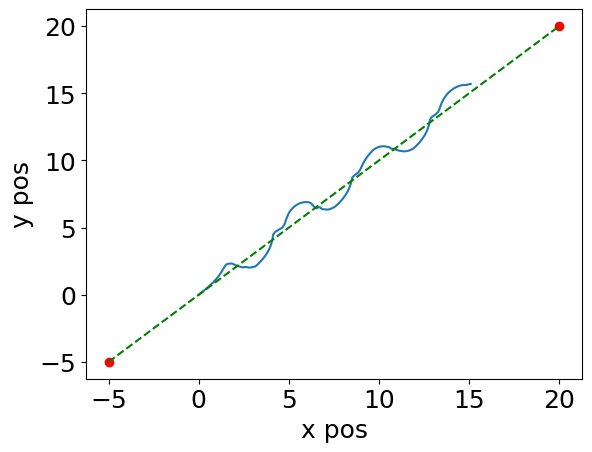

In [220]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['X'], x_sim['Y'])
#ax.plot(setpoint['X'], setpoint['Y'])
#Plot a point in aruci positions
ax.plot(20, 20, 'ro')
ax.plot(-5, -5, 'ro')
ax.set_xlabel('x pos')
ax.set_ylabel('y pos')
#Plot the line y =x
line_x = np.linspace(-5, 20, 400)
ax.plot(line_x, line_x, color='green', linestyle='--')



# Simulate noisy measurements

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [221]:
measurement_noise_stds = {
                          'theta': 0.1,
                          'thetadot': 0.1,
                          'v_body': 0.2,
                          'euc_aruco': 0.25,
                          'euc_aruco2': 0.25
                         }

In [222]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}
y_noisy

{'v_body': array([ 0.08490385,  1.26116732,  1.477148  ,  1.22115861,  1.51431235,
         1.41673813,  1.15855142,  1.50971433,  1.40807093,  1.69146898,
         1.62155581,  1.56822321,  1.12277836,  1.63628811,  0.98627188,
         1.24706711,  1.23233273,  0.7721233 , -0.21108182,  0.25892307,
        -1.57678146, -1.04674131, -0.53156689, -0.74762426, -0.80308317,
         0.81146062, -0.91908332, -0.83456671, -0.1471306 ,  0.03837456,
         0.64409996,  0.71176959,  1.35825496,  1.1568677 ,  0.89272093,
         1.29538352,  0.95057807,  0.95309911,  1.41666844,  1.44192743,
         0.97388072,  1.44268526,  1.29134963,  1.25266303,  1.22795134,
        -0.60087003, -1.12993117, -0.65414132,  1.04120494,  1.70741644,
         1.86895577,  1.78447345,  1.33406624,  0.95401594,  1.72048827,
         0.92795247,  0.26611578,  0.49432126,  0.22498197,  0.27260894,
         0.32947931, -1.24831446, -1.28487294, -1.38425855,  0.19923195,
         1.21391918, -0.09925918, -1.3101

<Axes: xlabel='Time', ylabel='euc_aruco'>

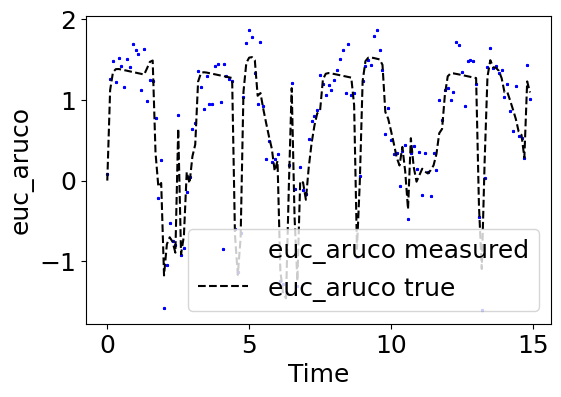

In [223]:
plot_tme(t_sim, y_sim['v_body'], y_noisy['v_body'], label_var='euc_aruco')

### Save data as dataframes

In [224]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Kalman filter parameters and initilization

In [225]:
x0 = np.ones(len(x_sim))*2
#x0 = np.array([-3, np.sin(-5) + 2, 1, 1, 1, 1])
u0 = np.zeros(2)
P0 = np.eye(len(x_sim))*1

In [226]:
R = np.diag( list(measurement_noise_stds.values()) )**2
Q = np.diag([1e-1]*len(x0))

In [227]:
dt = np.mean(np.diff(t_sim))

# Extended Kalman Filter

In [228]:
EKF = extended_kalman_filter.EKF(f, h_all, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 circular_measurements=(1,0,0,0,0,0,0))

In [229]:
EKF.estimate(y_noisy_df, u_sim_df)

In [230]:
EKF.history.keys()

dict_keys(['X', 'U', 'Z', 'P', 'P_diags', 'R', 'Q', 'F', 'H', 'S', 'K', 'E', 'rho', 'Jk', 'inv_Jk'])

In [231]:
# State estimate
x_est = pd.DataFrame(np.vstack(EKF.history['X']), columns=state_names)

In [232]:
# Covariance diagonals
P_diags = np.vstack([np.diag(EKF.history['P'][i]) for i in range(len(EKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=state_names)

0.8164580052422958


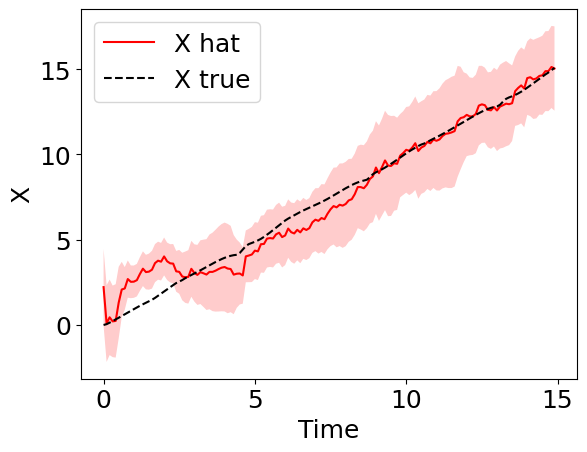

In [233]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'X'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
rmse = np.sqrt(np.mean((x_est[state] - x_sim[state])**2))
print(rmse)

0.8309690775761585


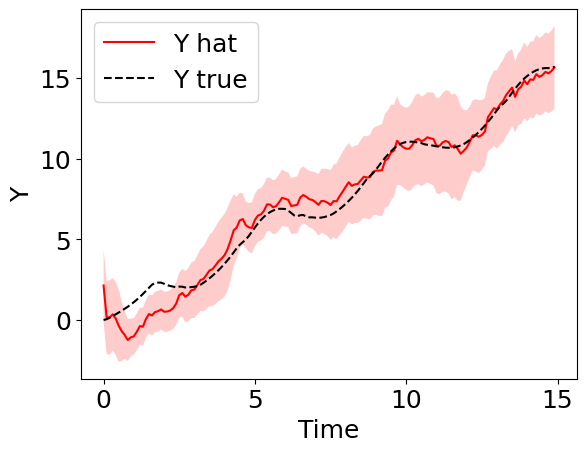

In [234]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'Y'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
rmse = np.sqrt(np.mean((x_est[state] - x_sim[state])**2))
print(rmse)

# Unscented Kalman Filter

In [235]:
UKF = unscented_kalman_filter.UKF(f, h_all, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 alpha=0.1)

In [236]:
UKF.estimate(y_noisy_df, u_sim_df)

In [237]:
UKF.history.keys()

dict_keys(['X', 'P', 'P_diags', 'sigma_points'])

In [238]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=state_names)

In [239]:
# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=state_names)

0.5749975063613068


"\n\nax.axhline(y=np.pi/2, color='green', linestyle='--')\nax.axhline(y=-np.pi/2, color='green', linestyle='--')\n\nd = x_sim[state] - np.ones(len(x_sim[state])) * -np.pi/2\ncrossings = np.where(np.diff(np.sign(d)) != 0)[0]\nprint(crossings)\nax.axvline(x=t_sim[crossings[0]], color='green', linestyle='--')\nd = x_sim[state] - np.ones(len(x_sim[state])) * np.pi/2\ncrossings = np.where(np.diff(np.sign(d)) != 0)[0]\nax.axvline(x=t_sim[crossings[0]], color='green', linestyle='--')\nprint(crossings)"

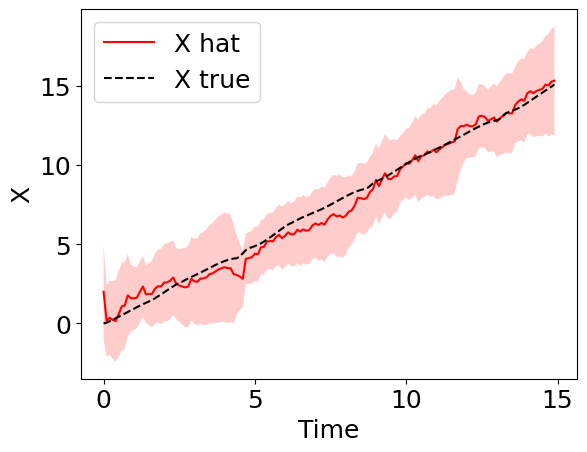

In [240]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'X'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

rmse = np.sqrt(np.mean((x_est[state] - x_sim[state])**2))
print(rmse)

"""

ax.axhline(y=np.pi/2, color='green', linestyle='--')
ax.axhline(y=-np.pi/2, color='green', linestyle='--')

d = x_sim[state] - np.ones(len(x_sim[state])) * -np.pi/2
crossings = np.where(np.diff(np.sign(d)) != 0)[0]
print(crossings)
ax.axvline(x=t_sim[crossings[0]], color='green', linestyle='--')
d = x_sim[state] - np.ones(len(x_sim[state])) * np.pi/2
crossings = np.where(np.diff(np.sign(d)) != 0)[0]
ax.axvline(x=t_sim[crossings[0]], color='green', linestyle='--')
print(crossings)"""

0.5896769930469961


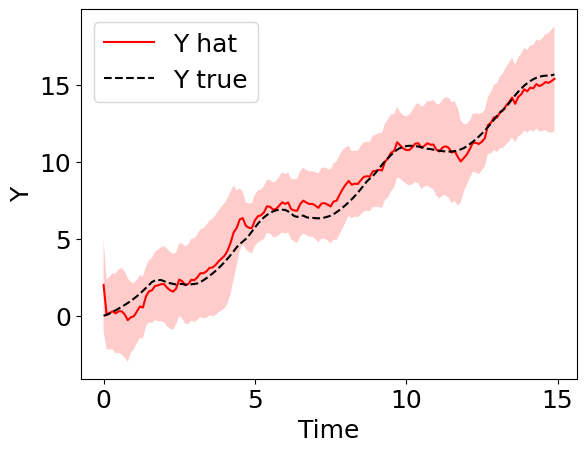

In [241]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'Y'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
rmse = np.sqrt(np.mean((x_est[state] - x_sim[state])**2))
print(rmse)


### Look at the sigma points

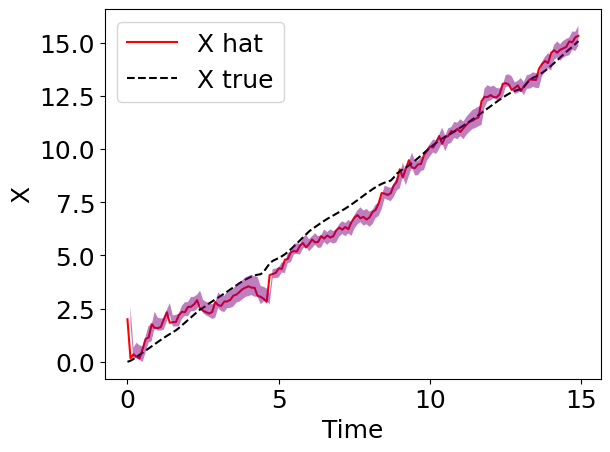

In [242]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'X'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

#plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
#minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])
#ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

state_ix = state_names.index(state)

sigma_lo = UKF.history['sigma_points'][state_ix,0,:]
sigma_hi = UKF.history['sigma_points'][state_ix,-1,:]
ax.fill_between(t_sim[1:], sigma_lo, sigma_hi, facecolor='purple', edgecolor='none', alpha=0.5, zorder=100)


# Exercises

1. Compare the UKF results, and error covariance, for the `alternating` and `squiggle` trajectory types. Do the results match the expectation from the observability analysis? What matches and what does not? Can you explain why?
2. Change the `alpha` parameter for the UKF, what changes do you see? Look at the sigma points.
3. Try a different measurement function, like:

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[pink]{k} \\[0.3em]
\end{bmatrix}
$

Note, this measurement function is accessible as `planar_drone.H('h_camera_theta_k').h`